In [1]:
# This notebook is best viewed in slide mode with certain nbextensions enabled: "RISE", hide input", "splitcells".
# It will look different "odd" without these extensions.

# L96 analogs for this project

## Analog for the real world

Lorenz, 1996, two time-scale equations, with accurate time-stepping (RK4 with sufficiently small $\Delta t$):
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - X_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k
\end{align}

We should agree and fix $F$, $J$ and $K$ for this purpose.

# Analog for  GCM

Lorenz, 1996, one time-scale equation, with inaccurate time-stepping (Euler-forward with only-just stable $\Delta t$) and an unknown parameterization of "unresolved processes), $P(X_k)$:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - P\left( X_k \right)
\end{align}

Wilks, 2005, used $P(X_k)=b_0 + b_1 X_k + b_2 X_k^2 + b_3 X_k^3 + b_4 X_k^4 + e_k$ where $e_k$ is a stochastic component.
Arnold et al., 2013, used $P(X_k)=b_0 + b_1 X_k + b_2 X_k^2 + b_3 X_k^3 + e_k$.

# The real world

Wilks, 2005 used
- $F=18$ or $20$
- $K=8$
- $J=32$

Traditional to use
- $h=1$
- $b=10$
- $c=10$

Wall time: 2.58 s


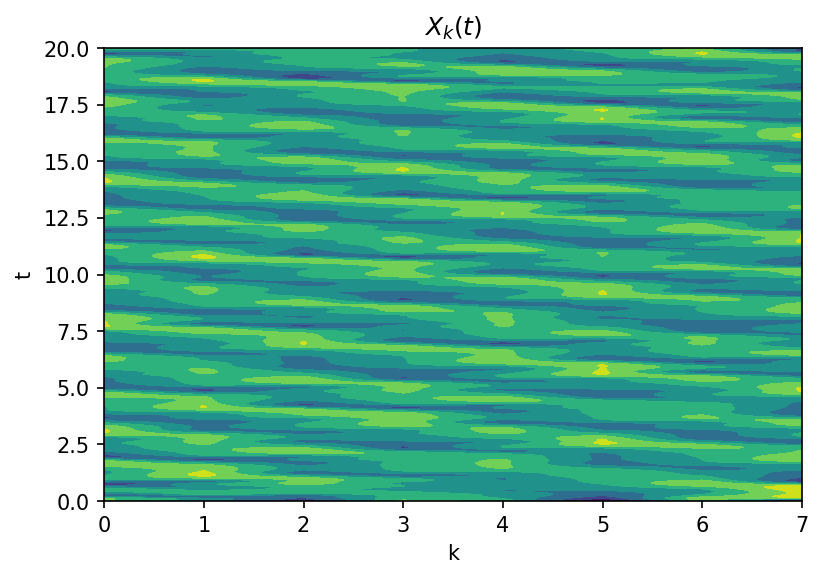

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from L96_model import L96

np.random.seed(23)
W = L96(8, 32)

%time X,Y,t = W.run(0.01, 20.)

plt.figure(dpi=150)
plt.contourf(W.k, t, X)
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$");

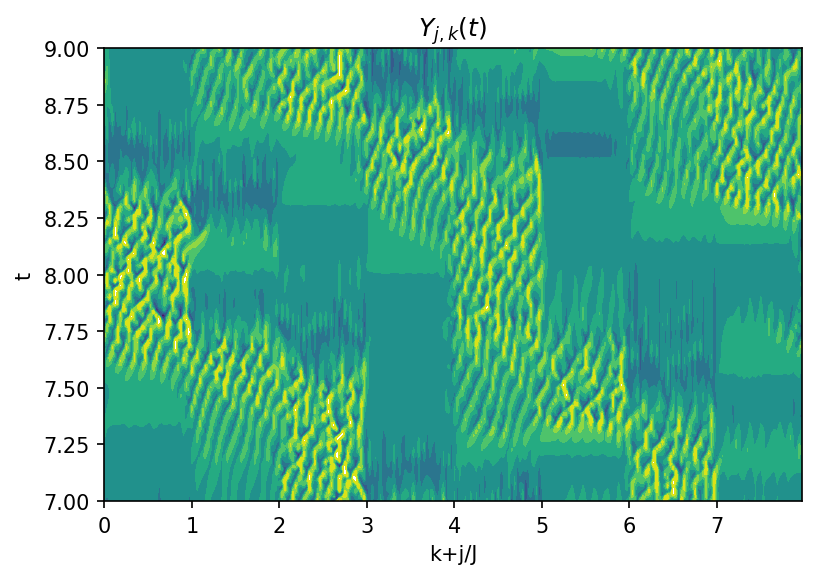

In [3]:
plt.figure(dpi=150)
plt.contourf(W.j / W.J, t, Y, levels=np.linspace(-1, 1, 10))
plt.xlabel("k+j/J")
plt.ylabel("t")
plt.title("$Y_{j,k}(t)$")
yl = plt.ylim(7, 9);

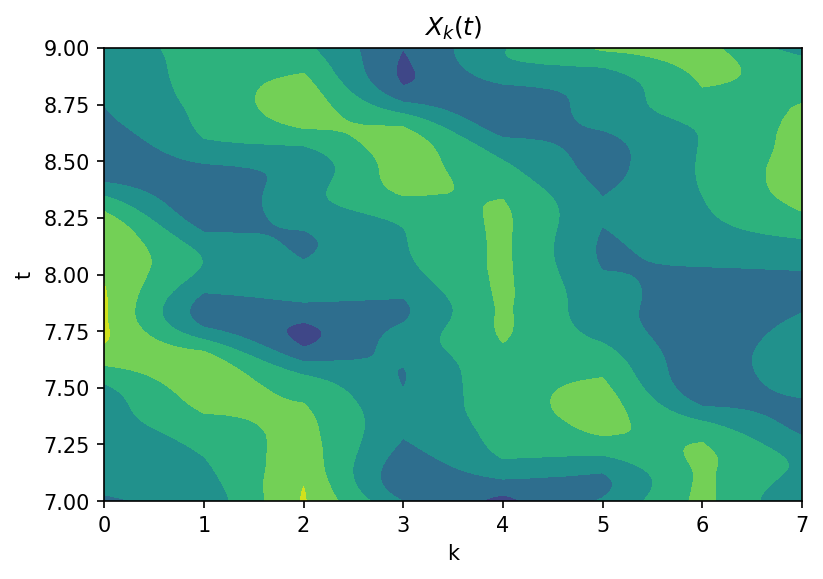

In [4]:
plt.figure(dpi=150)
plt.contourf(W.k, t, X)
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$")
plt.ylim(yl);

# The parametization $P(X_k)$

With the "real world" in hand, we can "observe" the sub-grid forcing on the large scale.

\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \underbrace{ 
\left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
}_{=U_k}
\end{align}

Need to model actual coupling, $U_k$, with function $P(X_k)$.

Note the sign of the slope of $P(X_k)$ determines sign of the feedback.

In [5]:
%time X, Y, t = W.run(0.05, 200.)

Wall time: 7.27 s


In [6]:
Xsamp = X
Usamp = (W.h * W.c / W.b) * Y.reshape((Y.shape[0], W.K, W.J)).sum(axis=-1)
p = np.polyfit(Xsamp.flatten(), Usamp.flatten(), 1)
print("Poly coeffs:", p)

Poly coeffs: [0.85439536 0.75218026]


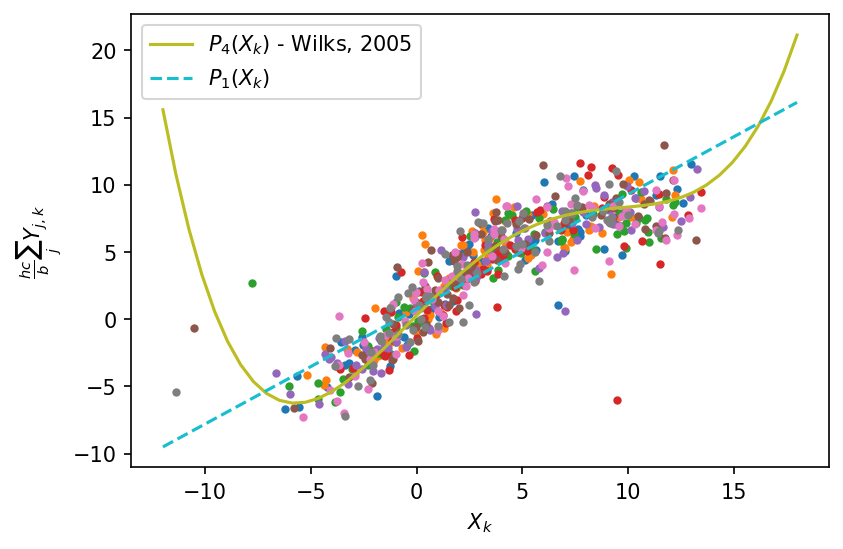

In [7]:
plt.figure(dpi=150)
plt.plot(Xsamp[::50, :], Usamp[::50, :], ".")
plt.xlabel("$X_k$")
plt.ylabel(r"$\frac{hc}{b}\sum_j Y_{j,k}$")
x = np.linspace(-12, 18)
p18 = [0.000707, -0.0130, -0.0190, 1.59, 0.275]  # Polynomial from Wilks, 2005
plt.plot(x, np.polyval(p18, x), label="$P_4(X_k)$ - Wilks, 2005")
plt.plot(x, np.polyval(p, x), "--", label="$P_1(X_k)$")
plt.legend();

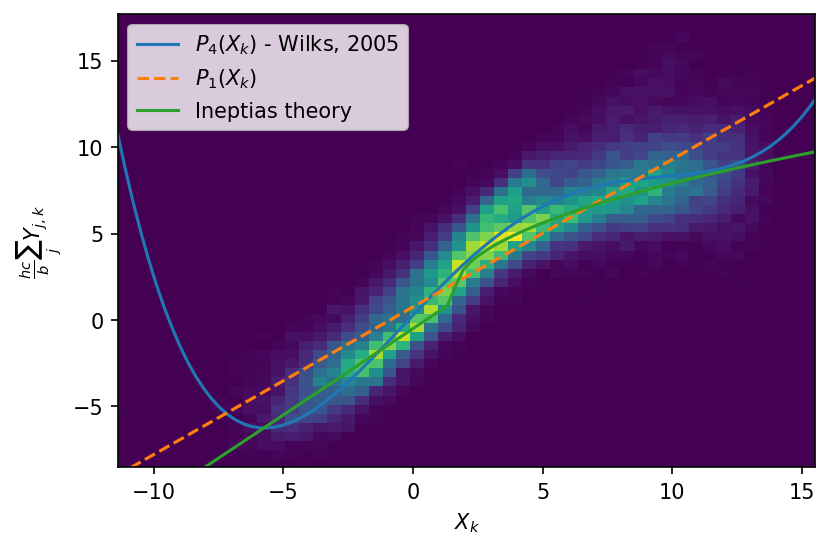

In [8]:
plt.figure(dpi=150)
plt.hist2d(Xsamp.flatten(), Usamp.flatten(), bins=50)
plt.xlabel("$X_k$")
plt.ylabel(r"$\frac{hc}{b}\sum_j Y_{j,k}$")
x = np.linspace(-12, 18, 100)
p18 = [0.000707, -0.0130, -0.0190, 1.59, 0.275]  # Polynomial from Wilks, 2005
plt.plot(x, np.polyval(p18, x), label="$P_4(X_k)$ - Wilks, 2005")
plt.plot(x, np.polyval(p, x), "--", label="$P_1(X_k)$")
plt.plot(
    x,
    np.minimum(1.5, x - 0.5) + 2.2 * np.sqrt(np.maximum(0, x - 1.5)),
    label="Ineptias theory",
)
plt.legend();

# The model "GCM"

\begin{align}
\frac{d}{dt} X_k
&= \underbrace{- X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F}_{\dot{X}\text{ from eq. (1) of Lorenz '96}} - P(X_k)
\end{align}

In [9]:
from L96_model import L96_eq1_xdot


def GCM(X0, F, dt, nt, param=[0]):
    time, hist, X = dt * np.arange(nt), np.zeros((nt, len(X0))) * np.nan, X0.copy()

    for n in range(nt):
        X = X + dt * (L96_eq1_xdot(X, F) - np.polyval(param, X))
        if np.abs(X).max() > 1e3:
            break
        hist[n], time[n] = X, dt * (n + 1)
    return hist, time


np.random.seed(13)
T = 5
Xtrue, Ytrue, Ttrue = W.randomize_IC().run(0.05, T)
Xinit, dt, Fmod = Xtrue[0] + 0.0 * np.random.randn(W.K), 0.002, W.F + 0.0
Xgcm1, Tgcm1 = GCM(Xinit, Fmod, dt, int(T / dt))
Xgcm2, Tgcm2 = GCM(Xinit, Fmod, dt, int(T / dt), param=p)
Xgcm3, Tgcm3 = GCM(Xinit, Fmod, dt, int(T / dt), param=p18)

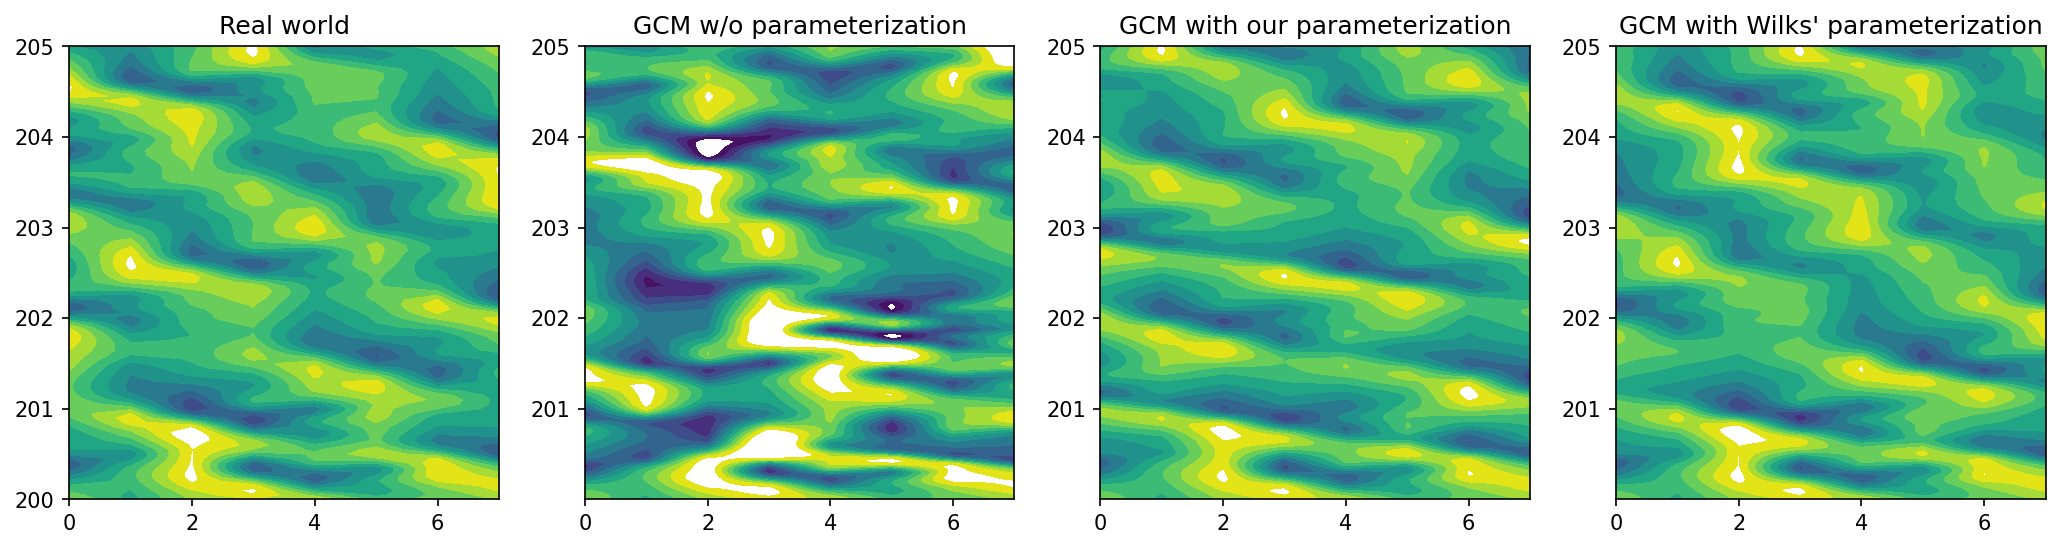

In [10]:
plt.figure(dpi=150, figsize=(17, 4))
lims = {"vmin": -12, "vmax": 12, "levels": np.linspace(-12, 12, 12)}
plt.subplot(141)
plt.contourf(W.k, Ttrue + t[-1], Xtrue, **lims)
plt.title("Real world")
plt.subplot(142)
plt.contourf(W.k, Tgcm1 + t[-1], Xgcm1, **lims)
plt.title("GCM w/o parameterization")
plt.subplot(143)
plt.contourf(W.k, Tgcm3 + t[-1], Xgcm2, **lims)
plt.title("GCM with our parameterization")
plt.subplot(144)
plt.contourf(W.k, Tgcm2 + t[-1], Xgcm3, **lims)
plt.title("GCM with Wilks' parameterization");

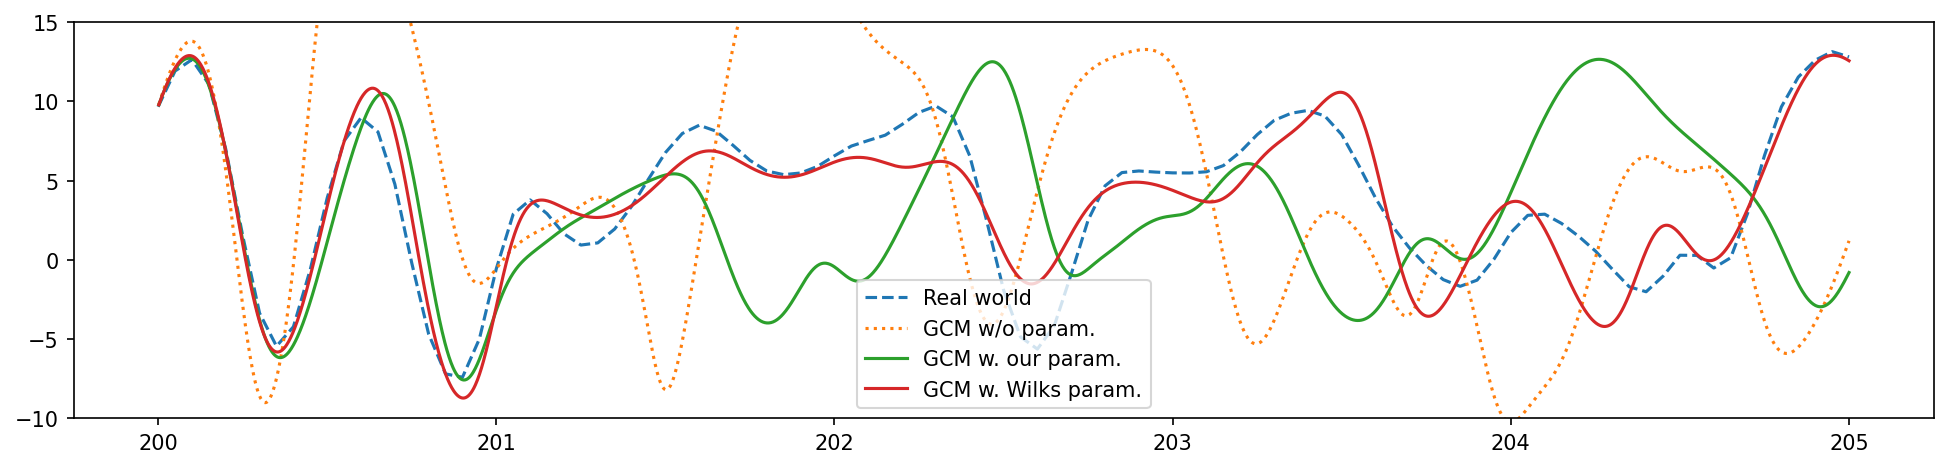

In [11]:
k = 3
plt.figure(dpi=150, figsize=(16, 3.5))
plt.plot(Ttrue + t[-1], Xtrue[:, k], "--", label="Real world")
plt.plot(Tgcm1 + t[-1], Xgcm1[:, k], ":", label="GCM w/o param.")
plt.plot(Tgcm1 + t[-1], Xgcm2[:, k], label="GCM w. our param.")
plt.plot(Tgcm1 + t[-1], Xgcm3[:, k], label="GCM w. Wilks param.")
plt.legend()
plt.ylim(-10, 15);

# Model error

- Missing physics, or poorly parameterized unresolved physics
  - $P_4 \rightarrow P_1$
- Unknown forcing
  - $F \rightarrow F + error$
- Numerical errors
  - $\Delta t \rightarrow 10 \Delta t$
- Initialization error
  - $X(t=0) \rightarrow X(t=0) + error$

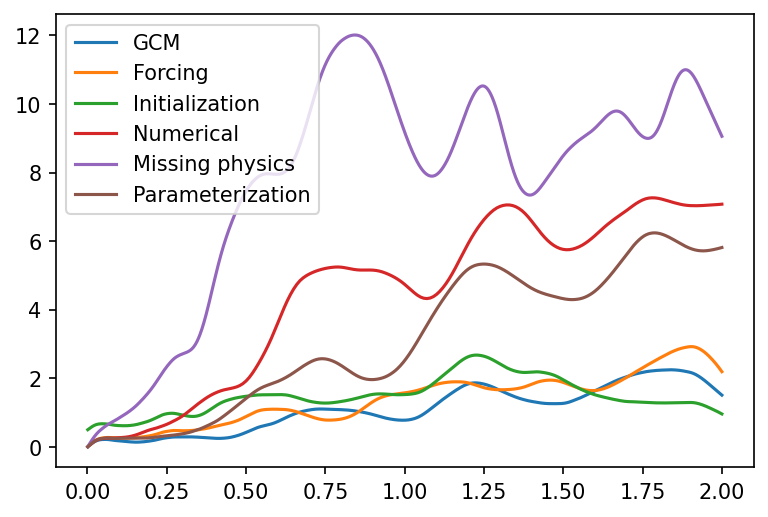

In [12]:
def err(X, Xtrue):
    return np.sqrt(((X - Xtrue[1:, :]) ** 2).mean(axis=1))


np.random.seed(13)
T, dt = 2, 0.001
Xtr, _, _ = W.randomize_IC().set_param(0.0001).run(dt, T)
Xgcm, Tc = GCM(W.X, W.F, dt, int(T / dt), param=p18)
Xfrc, Tc = GCM(W.X, W.F + 1.0, dt, int(T / dt), param=p18)
Xic, Tc = GCM(W.X + 0.5, W.F, dt, int(T / dt), param=p18)
Xdt, Tdt = GCM(W.X, W.F, 10 * dt, int(T / dt / 10), param=p18)
Xphys, _ = GCM(W.X, W.F, dt, int(T / dt))
Xprm, _ = GCM(W.X, W.F, dt, int(T / dt), param=p)

plt.figure(dpi=150)
plt.plot(Tc, err(Xgcm, Xtr), label="GCM")
plt.plot(Tc, err(Xfrc, Xtr), label="Forcing")
plt.plot(Tc, err(Xic, Xtr), label="Initialization")
plt.plot(Tdt, err(Xdt, Xtr[::10]), label="Numerical")
plt.plot(Tc, err(Xphys, Xtr), label="Missing physics")
plt.plot(Tc, err(Xprm, Xtr), label="Parameterization")
plt.legend();

In [13]:
# Build a 100-"day" climatology

T, dt = 100.0, 0.001
%time Xclim,Yclim,Tclim = W.run(0.1, T)
%time X1,t1 = GCM(Xinit, Fmod, dt, int(T/dt), param=p)
%time X2,t2 = GCM(Xinit, Fmod, dt, int(T/dt), param=p18)

Wall time: 36.5 s
Wall time: 1.95 s
Wall time: 2.69 s




       Truth      P1   Wilks
mean:  3.741   2.926   3.750
std:   4.679   4.375   4.524


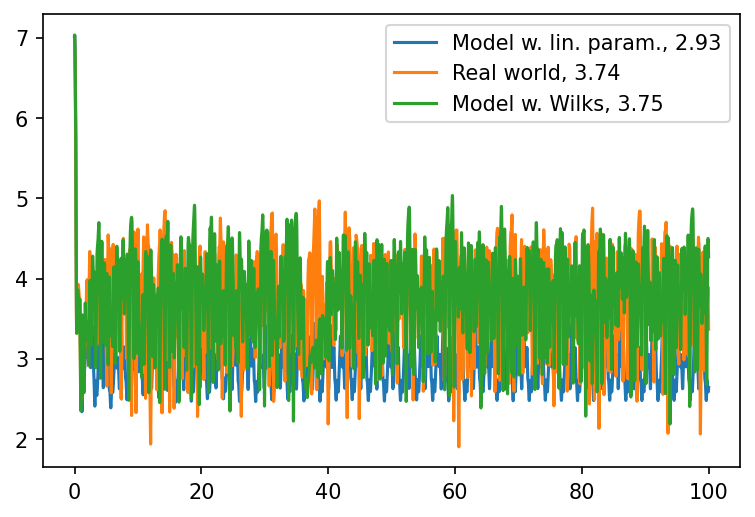

In [14]:
plt.figure(dpi=150)
plt.plot(t1, X1.mean(axis=1), label="Model w. lin. param., %.2f" % (X1.mean()))
plt.plot(Tclim, Xclim.mean(axis=1), label="Real world, %.2f" % (Xtrue.mean()))
plt.plot(t2, X2.mean(axis=1), label="Model w. Wilks, %.2f" % (X2.mean()))
plt.legend()
print("\n\n       Truth      P1   Wilks")
print("mean:  %.3f   %.3f   %.3f" % (Xtrue.mean(), X1.mean(), X2.mean()))
print("std:   %.3f   %.3f   %.3f" % (Xtrue.std(), X1.std(), X2.std()))

In [15]:
def GCMs(X0, F, dt, nt, param=[0], stoch=1.0, phi=0.984):
    time, hist, X = dt * np.arange(nt), np.zeros((nt, len(X0))) * np.nan, X0.copy()
    ek = np.zeros(X.size)

    for n in range(nt):
        # Red noise
        ek = phi * ek + stoch * np.sqrt((1 - phi) * (1 + phi)) * np.random.randn(X.size)
        X = X + dt * (L96_eq1_xdot(X, F) - np.polyval(param, X) + stoch * ek)
        if np.abs(X).max() > 1e3:
            break
        hist[n], time[n] = X, dt * (n + 1)
    return hist, time


np.random.seed(31)
%time X3,t3 = GCMs(Xinit, Fmod, dt, int(T/dt), param=p18)

print("\n\n       Truth      P1      P4  P4+stoch")
print(
    "mean:  %.3f   %.3f   %.3f   %.3f" % (Xtrue.mean(), X1.mean(), X2.mean(), X3.mean())
)
print("std:   %.3f   %.3f   %.3f   %.3f" % (Xtrue.std(), X1.std(), X2.std(), X3.std()))

Wall time: 3.46 s


       Truth      P1      P4  P4+stoch
mean:  3.741   2.926   3.750   3.758
std:   4.679   4.375   4.524   4.537


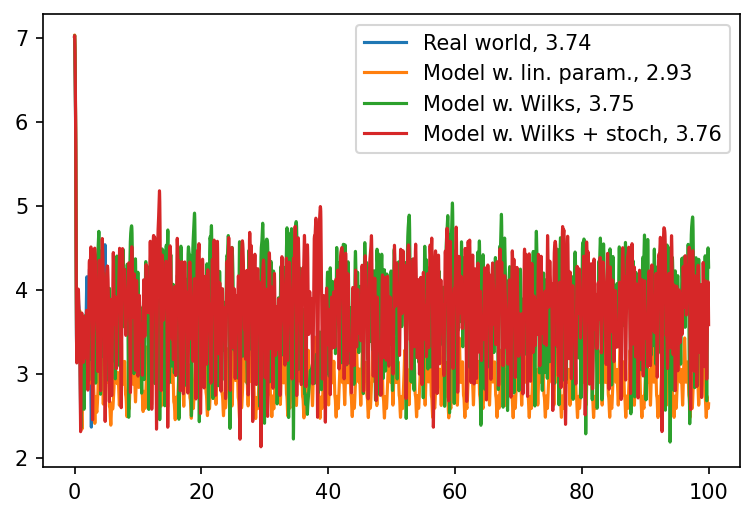

In [16]:
plt.figure(dpi=150)
plt.plot(Ttrue, Xtrue.mean(axis=1), label="Real world, %.2f" % (Xtrue.mean()))
plt.plot(t1, X1.mean(axis=1), label="Model w. lin. param., %.2f" % (X1.mean()))
plt.plot(t2, X2.mean(axis=1), label="Model w. Wilks, %.2f" % (X2.mean()))
plt.plot(t3, X3.mean(axis=1), label="Model w. Wilks + stoch, %.2f" % (X3.mean()))
plt.legend();

# Summary

- Used L96 two time-scale model to generate a real world, or "truth", dataset
- Build a "GCM" with a rudimentary parameterization of coupling to unresolved processes ($\frac{hc}{b}\sum_{j=0}^{J-1} Y_{j,k}$)
  - Deliberately using low-order integration and longer time-step for non-trivial numerical model errors


### Software questions

- `numba` package needed for efficiency but can be temperamental
- Should we make this L96 model package? Would that make it easier/harder to build subsequent exercises?
- We could store data to files to exercise packages such as `xarray` - in practice we will do most training via file...
